<span style="font-size: 24px; font-weight: bold;">Libraries</span>  

In [1]:
#Read libraries
import gzip
import json

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Process data libraries
import pandas as pd
import numpy as np
import ast

#Sentimental Analysis library
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('vader_lexicon')

# Detection Lenguaje library
from langdetect import detect

#Similarity Cosine libraries
from sklearn.metrics.pairwise import cosine_similarity

#Process Checking library
from tqdm import tqdm 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\otalo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\otalo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Sources Paths
ST = 'Sources\\steam_games.json.gz'
UR = 'Sources\\user_reviews.json.gz'
UI = 'Sources\\users_items.json.gz'

<span style="font-size: 24px; font-weight: bold;">ETL - Process</span>  

**Descompress, Read and Unnesting .json file**

Steam Games

In [3]:
#READING (Decompress and read json)  ------- 'steam_games' database

SG_df = pd.read_json(ST, lines=True, compression='gzip', dtype={'id':object})
SG_df = pd.DataFrame(SG_df)

User Reviews

In [4]:
#READING (Decompress and read json) ------- 'user_reviews' database
Read = []
non_read = []

with gzip.open(UR,'rt',encoding='utf-8') as archivo:
    for number_line, line in enumerate(archivo,start=1):
        #print(line)
        try:
            data = json.loads(line)
            Read.append(data)
            

        except json.JSONDecodeError as e:
            #print(f"Error al decodificar JSON en la l�nea {number_line}: {e}")
            try:
                data = ast.literal_eval(line) # Mas seguro (than eval()). manejar expresiones literales simples, como n�meros, cadenas, listas, diccionarios, tuplas y valores booleanos.
                if isinstance(data,dict):
                    Read.append(data)
                else:
                    non_read.append(number_line)
            except json.JSONDecodeError as e:
                non_read.append(number_line)

UR_DF = pd.DataFrame(Read)
UR_DF.head(2)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."


In [5]:
# UNNESTING of column reviews  ------- 'user_reviews' database --- spent 5 minutes 39.8 seg

UR_unnesting_DF = pd.DataFrame()

for indice, row in UR_DF.iterrows():
    user_id = row['user_id']
    user_url = row['user_url']
    reviews = row['reviews']

    for diccionario in reviews:
        fila = {'user_id':user_id,'user_url':user_url,**diccionario}
        UR_unnesting_DF = pd.concat([UR_unnesting_DF, pd.DataFrame([fila])], ignore_index=True)

UR_unnesting_DF

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...,...,...,...,...
59300,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...
59301,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...
59302,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...
59303,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,,Posted July 20.,,730,No ratings yet,True,:D


User Items

In [6]:
#READING (Decompress and read json)  ------- 'user_items' database # With counters spent 2 min 48.2 seg and without counters was 2min 36 seg
Read = []
non_read = []

with gzip.open(UI,'rt',encoding='utf-8') as archivo:
    for number_line, line in enumerate(archivo,start=1):
        try:
            data = json.loads(line)
            Read.append(data)
                       
        except json.JSONDecodeError as e:
            
            try:
                data = ast.literal_eval(line) # Mas seguro. manejar expresiones literales simples, como n�meros, cadenas, listas, diccionarios, tuplas y valores booleanos.
                if isinstance(data,dict):
                    Read.append(data)
                else:
                    non_read.append(number_line)
                    
            except json.JSONDecodeError as e:
                non_read.append(number_line)

UI_DF = pd.DataFrame(Read)
UI_DF.head(2)

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."


In [7]:
# UNNESTING (third)  ------- Extracting 'items' from the user_items database and unnesting # It takes only 14.6 seconds.

# Take the 'items' column, convert each element of the list into rows, and preserve their respective indices.
item_column = UI_DF['items'].explode()

# Filter elements that are not dictionaries.
item_column_filter = item_column[item_column.apply(lambda x: isinstance(x, dict))]

# Identify the data type of elements that are not dictionaries.
#b = a[~a.apply(lambda x: isinstance(x, dict))].unique() # I Found out that rows that aren't diccionaries, are 'nan'

# Convert this series into a dataframe and maintain their respective indices.
UI_unnesting_DF = pd.DataFrame(list(item_column_filter), index=item_column_filter.index)

# Merge with the original index and reset the index.
UI_unnesting_DF = pd.merge(UI_DF,UI_unnesting_DF, how='left', left_index=True, right_index=True).reset_index()
UI_unnesting_DF.head(2)

,index,user_id,items_count,steam_id,user_url,items,item_id,item_name,playtime_forever,playtime_2weeks
0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...",10,Counter-Strike,6.0,0.0
1,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...",20,Team Fortress Classic,0.0,0.0


<span style="font-size: 24px; font-weight: bold;">Sentimental Analysis</span> **(Clasification)**

In [8]:
# Identify sentiment analysis (compound) using the following distribution:        # 
# Positive: Values greater than 0.1 (or even 0.2). Should be labeled as 2.
# Neutral: Values in the range of -0.1 to 0.1. Should be labeled as 1.
# Negative: Values less than -0.1 (or even -0.2). Should be labeled as 0.

analyzer = SentimentIntensityAnalyzer()
UR_unnesting_DF['sentimental'] = UR_unnesting_DF['review'].apply(lambda x: 2 if (list((analyzer.polarity_scores(x)).values())[3]) > 0.1
                                                                                                else ( 1 if (list((analyzer.polarity_scores(x)).values())[3]) >= -0.1 else 0 ))

In [9]:
# Adding the original sentiment score (compound) from sentimental analysis
UR_unnesting_DF['sentimental_2'] = UR_unnesting_DF['review'].apply(lambda x: list((analyzer.polarity_scores(x)).values())[3])

In [10]:
# TESTING --- Verifying that all rows have undergone sentiment analysis.
#user_reviews_unnesting_df[user_reviews_unnesting_df['sentiment_score'] > 0.1]['sentiment'].unique()
#user_reviews_unnesting_df[(user_reviews_unnesting_df['sentiment_score'] >= -0.1) & (user_reviews_unnesting_df['sentiment_score'] <= 0.1)]['sentiment'].unique()
#user_reviews_unnesting_df[user_reviews_unnesting_df['sentiment_score'] < -0.1]['sentiment'].unique()


<span style="font-size: 24px; font-weight: bold;">EDA - Analysis of sentimental score close to **ZERO** or equal to zero</span>  

Text(0.5, 1.0, 'ZOOM IN - (-0.25 to 0.25)')

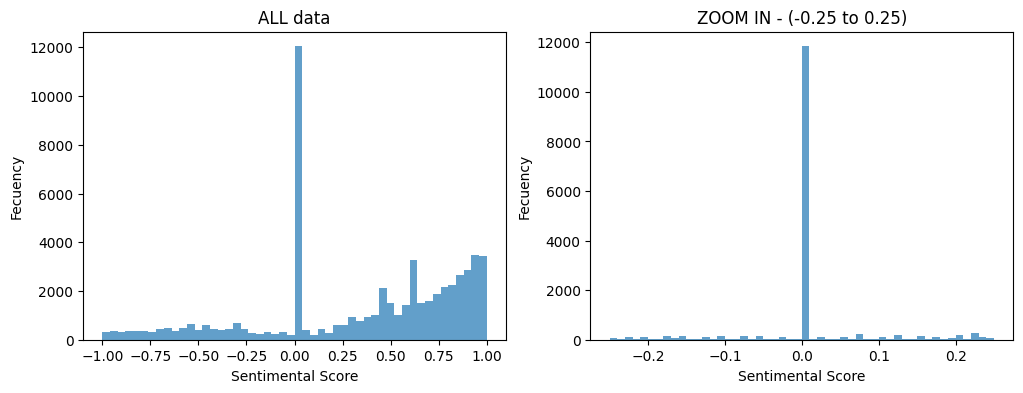

In [11]:
# Analyzing Sentiment Scores Near Zero or Equal to Zero
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].hist(UR_unnesting_DF['sentimental_2'], bins=50, alpha=0.7) # Found out -0.25 and 0.25 tehre are many rows. Iteration 2 beter  zoom between -0.025 to 0.025
axs[0].set_xlabel('Sentimental Score')
axs[0].set_ylabel('Fecuency')
axs[0].set_title('ALL data')

zoom_close_to_zero = UR_unnesting_DF[(UR_unnesting_DF['sentimental_2'] > -0.25) & (UR_unnesting_DF['sentimental_2']<0.25)]['sentimental_2']
zoom_close_to_zero
axs[1].hist(zoom_close_to_zero, bins=50, alpha=0.7)
axs[1].set_xlabel('Sentimental Score')
axs[1].set_ylabel('Fecuency')
axs[1].set_title('ZOOM IN - (-0.25 to 0.25)')



**Insight**:  
Visually it can see that the most frecuency is around of zero.

In [12]:
# Analysis of each review: In which language is it written?
# It's possible that some of the reviews with a zero sentiment score are due to being written in another language.


languajes = []

for row, i in enumerate(UR_unnesting_DF['review'],start=0):
    total = UR_unnesting_DF.shape[0]
    
    try:
        languajes.append(detect(i))
    
        

    except Exception as e:
        languajes.append('Languaje non-detected')

In [13]:
# Assign a language to each review
UR_unnesting_DF['languaje'] = languajes

[Text(0, 0, '77.1'),
 Text(0, 0, '3.7'),
 Text(0, 0, '2.2'),
 Text(0, 0, '1.9'),
 Text(0, 0, '1.7'),
 Text(0, 0, '1.3'),
 Text(0, 0, '1.2'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '0.8')]

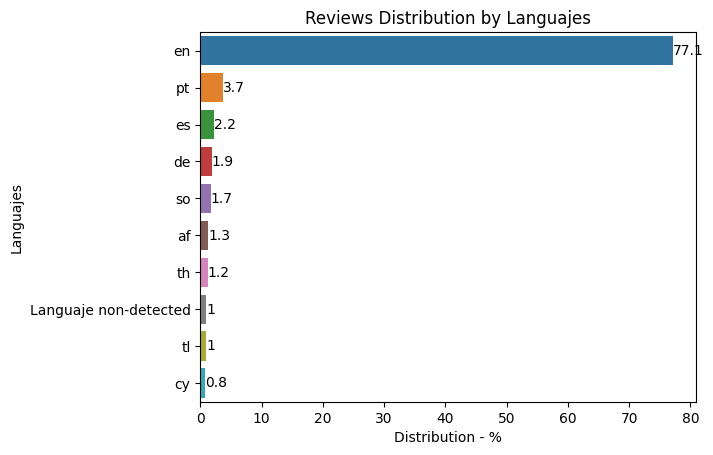

In [14]:
# Distribution of reviews by language - TOTAL:
# Count the reviews by language and calculate the percentage.

# Count the number of reviews for each language and create a DataFrame.
languajes_distribution = UR_unnesting_DF['languaje'].value_counts().to_frame().reset_index()

# Calculate the percentage of each language and round it to one decimal place.
languajes_distribution['%'] = round((languajes_distribution['count']/languajes_distribution['count'].sum())*100,1)

# Calculate the cumulative percentage of reviews by language.
languajes_distribution['Acum'] = round((languajes_distribution['count'].cumsum()/languajes_distribution['count'].sum())*100,1)

# Display a bar plot showing the distribution of reviews for the top 10 languages.
PLOT = sns.barplot(languajes_distribution.head(10), x='%', y='languaje')

# Set labels for the x and y axes.
PLOT.set_xlabel('Distribution - %')
PLOT.set_ylabel('Languajes')

# Set the title of the plot.
PLOT.set_title('Reviews Distribution by Languajes')

# Add labels to the bars in the bar plot.
PLOT.bar_label(PLOT.containers[0])



**Insight:**  
77% of al reviews are written in english.

[Text(0, 0, '19.9'),
 Text(0, 0, '2.3'),
 Text(0, 0, '2.2'),
 Text(0, 0, '1.9'),
 Text(0, 0, '1.1'),
 Text(0, 0, '0.8'),
 Text(0, 0, '0.8'),
 Text(0, 0, '0.8'),
 Text(0, 0, '0.7'),
 Text(0, 0, '0.6')]

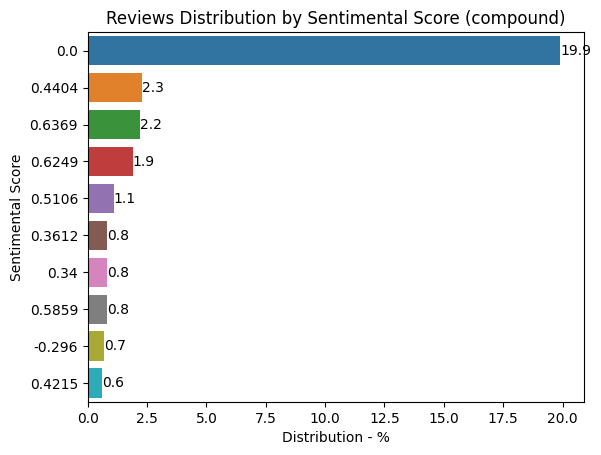

In [15]:
# Distribution of reviews by Sentimental Score - TOTAL:
# Count the occurrences of each sentimental score and calculate the percentage.

senti_score_distribution = UR_unnesting_DF['sentimental_2'].value_counts().to_frame().reset_index()
senti_score_distribution['%'] = round((senti_score_distribution['count']/senti_score_distribution['count'].sum())*100,1)

# Calculate the cumulative percentage.

senti_score_distribution['Acum'] = round((senti_score_distribution['count'].cumsum()/senti_score_distribution['count'].sum())*100,1)

# Change the format of the 'sentimental_2' column from float to string.

senti_score_distribution['sentimental_2'] = senti_score_distribution['sentimental_2'].astype(str)

# Display a bar plot showing the distribution of reviews by Sentimental Score for the top 10 scores.

PLOT = sns.barplot(senti_score_distribution.head(10), x='%', y='sentimental_2')
PLOT.set_xlabel('Distribution - %')
PLOT.set_ylabel('Sentimental Score')
PLOT.set_title('Reviews Distribution by Sentimental Score (compound)')

PLOT.bar_label(PLOT.containers[0])


**Insight:**  
The highest frecuency of sentimental score is zero score with almost 20% of all reviews. This is non-normal.

[Text(0, 0, '41.1'),
 Text(0, 0, '12.5'),
 Text(0, 0, '5.3'),
 Text(0, 0, '4.4'),
 Text(0, 0, '4.2'),
 Text(0, 0, '3.5'),
 Text(0, 0, '2.5'),
 Text(0, 0, '2.2'),
 Text(0, 0, '1.9'),
 Text(0, 0, '1.8')]

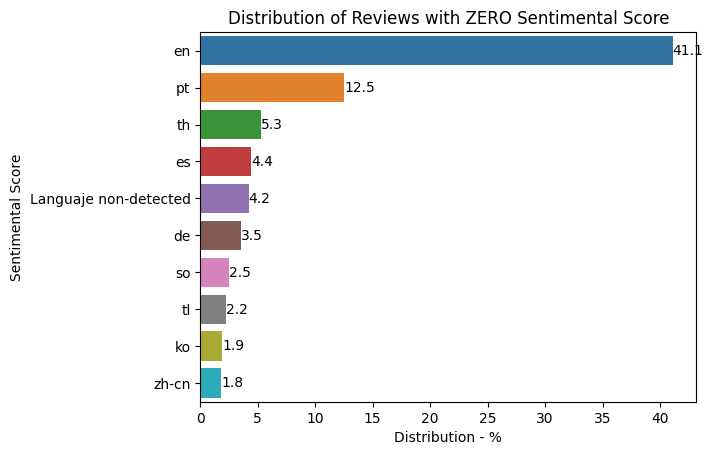

In [16]:
# Distribution of reviews by language - ONLY ZERO sentiment score:
# Count the reviews by language and calculate the percentage.
lang_zero_distribution = UR_unnesting_DF[UR_unnesting_DF['sentimental_2']==0]['languaje'].value_counts().to_frame().reset_index()
lang_zero_distribution['%'] = round((lang_zero_distribution['count']/lang_zero_distribution['count'].sum())*100,1)

# Calculate the cumulative percentage:
lang_zero_distribution['Acum'] = round((lang_zero_distribution['count'].cumsum()/lang_zero_distribution['count'].sum())*100,1)

# Almost 60% of reviews rated with ZERO sentiment are written in languages other than English.
PLOT = sns.barplot(lang_zero_distribution.head(10), x='%', y='languaje')
PLOT.set_xlabel('Distribution - %')
PLOT.set_ylabel('Sentimental Score')
PLOT.set_title('Distribution of Reviews with ZERO Sentimental Score')

PLOT.bar_label(PLOT.containers[0])

**Conclusion:**  
Approximately 77% of the reviews are composed in English.  
The most frequent sentiment score is ZERO, constituting 20% of the total reviews. Interestingly, 60% of that 20% are written in languages other than English. This explains the reason for the ZERO rating, as the NLTK library excels primarily with the English language.  

This issue can be addressed by implementing an alternative library capable of identifying various languages effectively.


<span style="font-size: 24px; font-weight: bold;">Functions</span>  

**(1) Most played year**

You must return the year with the most hours played for that genre.

In [17]:
# Performing transformations to obtain genres by title 
# Expanding the Steam games dataset by genres
explo_gen_title = SG_df[['id','title','genres','release_date']].explode('genres')

# Removing rows with missing genre information
explo_gen_title.drop(explo_gen_title.loc[explo_gen_title['genres'].isna()].index, inplace=True)
explo_gen_title.drop(explo_gen_title.loc[explo_gen_title['release_date'].isna()].index, inplace=True)



In [18]:
# Function to verify the validity of values in the 'release_date' column
def valid_date(rdate):
    try:
        pd.to_datetime(rdate)
        return True
    except (TypeError, ValueError):
        return False
    
# Applying the 'is_valid_date' function to the 'release_date' field
explo_gen_title['release_date'] = explo_gen_title['release_date'].apply(lambda x: pd.to_datetime(x) if valid_date(x) else None)


C:\Users\otalo\AppData\Local\Temp\ipykernel_20400\1559091750.py:4: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pd.to_datetime(rdate)
C:\Users\otalo\AppData\Local\Temp\ipykernel_20400\1559091750.py:10: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  explo_gen_title['release_date'] = explo_gen_title['release_date'].apply(lambda x: pd.to_datetime(x) if valid_date(x) else None)


In [19]:
# Obtaining the year from the release_date
explo_gen_title['release_year'] = pd.DatetimeIndex(explo_gen_title['release_date']).year

explo_gen_title.head(5)

,id,title,genres,release_date,release_year
88310,761140,Lost Summoner Kitty,Action,2018-01-04,2018.0
88310,761140,Lost Summoner Kitty,Casual,2018-01-04,2018.0
88310,761140,Lost Summoner Kitty,Indie,2018-01-04,2018.0
88310,761140,Lost Summoner Kitty,Simulation,2018-01-04,2018.0
88310,761140,Lost Summoner Kitty,Strategy,2018-01-04,2018.0


In [20]:
# Combining the user_items dataset with the genres_by_title dataset to obtain played hours by title and by genre.
genres_title_hours = pd.merge(explo_gen_title,UI_unnesting_DF[['item_id','playtime_forever']], how='inner', left_on = 'id', right_on= 'item_id').reset_index()
genres_title_hours.head(5)

,index,id,title,genres,release_date,release_year,item_id,playtime_forever
0,0,282010,Carmageddon Max Pack,Action,1997-06-30,1997.0,282010,5.0
1,1,282010,Carmageddon Max Pack,Action,1997-06-30,1997.0,282010,0.0
2,2,282010,Carmageddon Max Pack,Action,1997-06-30,1997.0,282010,0.0
3,3,282010,Carmageddon Max Pack,Action,1997-06-30,1997.0,282010,0.0
4,4,282010,Carmageddon Max Pack,Action,1997-06-30,1997.0,282010,13.0


In [21]:
# Aggregating total playtime by genre and release year
genre_playtime = genres_title_hours[['genres','release_year','playtime_forever']].groupby(['genres','release_year']).sum()

# Resetting the index to obtain a flat DataFrame
genre_playtime.reset_index(inplace=True)

# Renaming the 'playtime_forever' column to 'total_playtime' for clarity
genre_playtime.rename(columns={"playtime_forever": "total_playtime"}, inplace=True)



In [22]:
# Determining the maximum playtime by genre
Genre_MaxPlayTime = genre_playtime[['genres','total_playtime']].groupby(['genres']).max()
Genre_MaxPlayTime.reset_index(inplace=True)
Genre_MaxPlayTime.rename(columns={"total_playtime": "max_playtime"}, inplace=True)
Genre_MaxPlayTime



,genres,max_playtime
0,Action,1.099063e+09
1,Adventure,2.243480e+08
2,Animation &amp; Modeling,1.354685e+06
3,Audio Production,4.662460e+05
4,Casual,8.251535e+07
5,Design &amp; Illustration,1.947406e+06
6,Early Access,1.203663e+08
7,Education,3.428040e+05
8,Free to Play,1.477287e+08
9,Indie,4.526728e+08


In [23]:
# Determining the release year by genre for the maximum total playtime
year_genre_Maxplaytime = pd.merge(Genre_MaxPlayTime,genre_playtime,how='left', on = 'genres').reset_index()
year_genre_Maxplaytime = year_genre_Maxplaytime[year_genre_Maxplaytime['total_playtime'] == year_genre_Maxplaytime['max_playtime']]
year_genre_Maxplaytime = year_genre_Maxplaytime[['genres','release_year']]


(1) Send to CVS (Source for API)

In [24]:
# Exporting the final dataset to a flat file
year_genre_Maxplaytime.to_csv('root/datos/_1_Genre_MaxPlayTime.csv',',',index=False)

(1) FastAPI Function

In [59]:
# Loading flat files to be used by the functions
year_genre_Maxplaytime = pd.read_csv("root/datos/_1_Genre_MaxPlayTime.csv")

def PlayTimeGenre(genre: str):
    '''Retrieve the release year with the highest played hours for the specified genre.'''
    # Obtain the corresponding year based on the genre
    year = year_genre_Maxplaytime.loc[year_genre_Maxplaytime['genres'].str.lower() == genre.lower(), 'release_year'].values
    if len(year) == 0:
        return {f'Videogame release year for the genre {genre}': 'no encontrado'}
    else:
        return {f'Videogame release year for the genre {genre}': str(year[0])}
    
PlayTimeGenre('Action')


{'Videogame release year for the genre Action': '2012.0'}

**(2) User who plays the most by genre**

Returns the user who accumulates the most hours played for the given genre.

In [26]:
# Combining the user_items dataset with the genres_by_title dataset to obtain the played hours by title and by genre.
hours_user_genres = pd.merge(explo_gen_title[['id','title','genres']],UI_unnesting_DF[['item_id', 'user_id','playtime_forever']], how='inner', left_on = 'id', right_on= 'item_id').reset_index()
hours_user_genres.head(5)

,index,id,title,genres,item_id,user_id,playtime_forever
0,0,282010,Carmageddon Max Pack,Action,282010,UTNerd24,5.0
1,1,282010,Carmageddon Max Pack,Action,282010,I_DID_911_JUST_SAYING,0.0
2,2,282010,Carmageddon Max Pack,Action,282010,76561197962104795,0.0
3,3,282010,Carmageddon Max Pack,Action,282010,r3ap3r78,0.0
4,4,282010,Carmageddon Max Pack,Action,282010,saint556,13.0


In [27]:
# Determining the total playtime for each user within each genre.

# Grouping the data by 'genres' and 'user_id' and calculating the sum of playtime_forever.
user_genre_total_playtime = hours_user_genres[['genres','user_id','playtime_forever']].groupby(['genres','user_id']).sum()

# Resetting the index to obtain a clean DataFrame.
user_genre_total_playtime.reset_index(inplace=True)

# Renaming the 'playtime_forever' column to 'total_playtime'.
user_genre_total_playtime.rename(columns={"playtime_forever": "total_playtime"}, inplace=True)

# Displaying the first 3 rows of the resulting DataFrame.
user_genre_total_playtime.head(3)

,genres,user_id,total_playtime
0,Action,--000--,139469.0
1,Action,--ace--,69325.0
2,Action,--ionex--,38315.0


In [28]:
#Calculating maximum playtime by genre
Genre_MaxPlayTime = user_genre_total_playtime[['genres','total_playtime']].groupby(['genres']).max()
Genre_MaxPlayTime.rename(columns={"total_playtime": "max_playtime"}, inplace=True)
Genre_MaxPlayTime.reset_index(inplace=True)
Genre_MaxPlayTime.head(3)

,genres,max_playtime
0,Action,1697650.0
1,Adventure,2183682.0
2,Animation &amp; Modeling,168314.0


In [29]:
# Identifying the user whose played hours by genre correspond to the maximum hours by genre.
user_genre_maxplaytime = pd.merge(Genre_MaxPlayTime,user_genre_total_playtime, how='left', on='genres').reset_index()

# Filter the rows where 'total_playtime' matches 'max_playtime'.
user_genre_maxplaytime = user_genre_maxplaytime[user_genre_maxplaytime['total_playtime'] == user_genre_maxplaytime['max_playtime']]

# Select only the 'genres' and 'user_id' columns.
user_genre_maxplaytime = user_genre_maxplaytime[['genres','user_id']]


(2) Send to CVS (Source for API)

In [30]:
# Saving the final dataset to a flat file
user_genre_maxplaytime.to_csv('root/datos/_2_User_MaxPlayTime.csv',',',index=False)

(2) FastAPI Function

In [31]:
# Loading flat files to be used by the functions
user_genre_maxplaytime = pd.read_csv("root/datos/_2_User_MaxPlayTime.csv")

    

def UserForGenre(genre: str):
    '''Retrieve the user with the highest accumulated hours played for the specified genre and a list of accumulated hours played per year.'''
    # Obtain the user associated with the genre
    user = user_genre_maxplaytime.loc[user_genre_maxplaytime['genres'].str.lower() == genre.lower(), 'user_id'].values
    if len(user) == 0:
        return {f'User with more hours played for Gen  {genre}': 'no encontrado'}
    else:
        return {f'User with more hours played for Gen  {genre}': str(user[0])}
    

UserForGenre('Adventure')


{'User with more hours played for Gen  Adventure': 'REBAS_AS_F-T'}

**(3) Top 3 recommended by User**

Returns the top 3 MOST recommended games by users for the given year.

In [32]:
# Applying the 'valid_date' function to the 'release_date' field.
SG_df['release_date'] = SG_df['release_date'].apply(lambda x: pd.to_datetime(x) if valid_date(x) else None)

# Extracting the year from the 'release_date' field.
SG_df['release_year'] = pd.DatetimeIndex(SG_df['release_date']).year

# Joining the 'steam_games' and 'user_reviews' datasets to consolidate data in a single location.
year_reviews = pd.merge(SG_df[['release_year', 'release_date', 'id', 'app_name', 'title']][SG_df.app_name.notna()], UR_unnesting_DF[['user_id', 'item_id','posted','recommend','sentimental']], how = 'inner', left_on = 'id', right_on = 'item_id').reset_index()
year_reviews.head(5)


C:\Users\otalo\AppData\Local\Temp\ipykernel_20400\1559091750.py:4: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pd.to_datetime(rdate)
C:\Users\otalo\AppData\Local\Temp\ipykernel_20400\332799787.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  SG_df['release_date'] = SG_df['release_date'].apply(lambda x: pd.to_datetime(x) if valid_date(x) else None)


,index,release_year,release_date,id,app_name,title,user_id,item_id,posted,recommend,sentimental
0,0,1997.0,1997-06-30,282010,Carmageddon Max Pack,Carmageddon Max Pack,InstigatorAU,282010,Posted January 12.,True,1
1,1,1998.0,1998-11-08,70,Half-Life,Half-Life,EizanAratoFujimaki,70,"Posted October 28, 2015.",True,2
2,2,1998.0,1998-11-08,70,Half-Life,Half-Life,GamerFag,70,"Posted January 27, 2011.",True,0
3,3,1998.0,1998-11-08,70,Half-Life,Half-Life,76561198020928326,70,"Posted July 1, 2014.",True,2
4,4,1998.0,1998-11-08,70,Half-Life,Half-Life,Bluegills,70,"Posted December 6, 2013.",True,2


In [33]:
# Updating Date Formats
import re
from datetime import datetime

# Function for transforming the 'posted' column into valid dates
def convert_dates(posted_date, rel_year):
    # Employing regular expressions to extract month, day, and year (if available) from the 'posted' field
    pattern = r"Posted (\w+) (\d+)(?:, (\d{4}))?"
    match = re.match(pattern, posted_date)
    if match:
        month = match.group(1)
        posted_day = int(match.group(2))
        posted_year = int(match.group(3)) if match.group(3) is not None else rel_year
        month_number = datetime.strptime(month, '%B').month
        try:
            valid_posted_date = pd.Timestamp(year=posted_year, month=month_number, day=posted_day)
            return valid_posted_date
        except (TypeError, ValueError):
            return None  # In case the conversion to Timestamp is unsuccessful, it returns None
    else:
        return None  # If 'posted_date' doesn't conform to the expected format, it returns None

# Creating the 'posted_date' column by transforming 'posted' into valid dates
year_reviews['posted_date'] = year_reviews.apply(lambda row: convert_dates(row['posted'], row['release_year']), axis=1)
year_reviews



,index,release_year,release_date,id,app_name,title,user_id,item_id,posted,recommend,sentimental,posted_date
0,0,1997.0,1997-06-30,282010,Carmageddon Max Pack,Carmageddon Max Pack,InstigatorAU,282010,Posted January 12.,True,1,NaT
1,1,1998.0,1998-11-08,70,Half-Life,Half-Life,EizanAratoFujimaki,70,"Posted October 28, 2015.",True,2,2015-10-28
2,2,1998.0,1998-11-08,70,Half-Life,Half-Life,GamerFag,70,"Posted January 27, 2011.",True,0,2011-01-27
3,3,1998.0,1998-11-08,70,Half-Life,Half-Life,76561198020928326,70,"Posted July 1, 2014.",True,2,2014-07-01
4,4,1998.0,1998-11-08,70,Half-Life,Half-Life,Bluegills,70,"Posted December 6, 2013.",True,2,2013-12-06
...,...,...,...,...,...,...,...,...,...,...,...,...
53983,53983,2004.0,2004-03-01,80,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero,76561198023508728,80,"Posted October 26, 2014.",False,1,2014-10-26
53984,53984,2004.0,2004-03-01,80,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero,Lone_walker,80,"Posted December 8, 2013.",True,2,2013-12-08
53985,53985,2004.0,2004-03-01,80,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero,green290,80,"Posted January 5, 2015.",True,1,2015-01-05
53986,53986,2004.0,2004-03-01,80,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero,174gamecuman700kngkakak,80,"Posted October 31, 2014.",True,1,2014-10-31


In [34]:
# Retrieving the year from the posted_date column
year_reviews['posted_year'] = pd.DatetimeIndex(year_reviews['posted_date']).year

# Display the first 5 records from the year_reviews dataframe
year_reviews .head(5)


,index,release_year,release_date,id,app_name,title,user_id,item_id,posted,recommend,sentimental,posted_date,posted_year
0,0,1997.0,1997-06-30,282010,Carmageddon Max Pack,Carmageddon Max Pack,InstigatorAU,282010,Posted January 12.,True,1,NaT,NaN
1,1,1998.0,1998-11-08,70,Half-Life,Half-Life,EizanAratoFujimaki,70,"Posted October 28, 2015.",True,2,2015-10-28,2015.0
2,2,1998.0,1998-11-08,70,Half-Life,Half-Life,GamerFag,70,"Posted January 27, 2011.",True,0,2011-01-27,2011.0
3,3,1998.0,1998-11-08,70,Half-Life,Half-Life,76561198020928326,70,"Posted July 1, 2014.",True,2,2014-07-01,2014.0
4,4,1998.0,1998-11-08,70,Half-Life,Half-Life,Bluegills,70,"Posted December 6, 2013.",True,2,2013-12-06,2013.0


In [35]:
# Highly Suggested
def more_recomended (recommended , review_sentiment):
    return 1 if ((recommended ==True) and ((review_sentiment == 1) or (review_sentiment == 2))) else 0

year_reviews['more_recommended'] = year_reviews.apply(lambda row: more_recomended(row['recommend'], row['sentimental']), axis=1)

year_reviews

,index,release_year,release_date,id,app_name,title,user_id,item_id,posted,recommend,sentimental,posted_date,posted_year,more_recommended
0,0,1997.0,1997-06-30,282010,Carmageddon Max Pack,Carmageddon Max Pack,InstigatorAU,282010,Posted January 12.,True,1,NaT,NaN,1
1,1,1998.0,1998-11-08,70,Half-Life,Half-Life,EizanAratoFujimaki,70,"Posted October 28, 2015.",True,2,2015-10-28,2015.0,1
2,2,1998.0,1998-11-08,70,Half-Life,Half-Life,GamerFag,70,"Posted January 27, 2011.",True,0,2011-01-27,2011.0,0
3,3,1998.0,1998-11-08,70,Half-Life,Half-Life,76561198020928326,70,"Posted July 1, 2014.",True,2,2014-07-01,2014.0,1
4,4,1998.0,1998-11-08,70,Half-Life,Half-Life,Bluegills,70,"Posted December 6, 2013.",True,2,2013-12-06,2013.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53983,53983,2004.0,2004-03-01,80,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero,76561198023508728,80,"Posted October 26, 2014.",False,1,2014-10-26,2014.0,0
53984,53984,2004.0,2004-03-01,80,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero,Lone_walker,80,"Posted December 8, 2013.",True,2,2013-12-08,2013.0,1
53985,53985,2004.0,2004-03-01,80,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero,green290,80,"Posted January 5, 2015.",True,1,2015-01-05,2015.0,1
53986,53986,2004.0,2004-03-01,80,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero,174gamecuman700kngkakak,80,"Posted October 31, 2014.",True,1,2014-10-31,2014.0,1


In [36]:
# Calculating the frequency of game recommendations for each year
recommended_year_games = year_reviews[['id','title','posted_year','more_recommended']].groupby(['id','title','posted_year']).sum()
recommended_year_games.reset_index(inplace=True)
recommended_year_games.rename(columns={"more_recommended": "times_recommended"}, inplace=True)
recommended_year_games = recommended_year_games.sort_values(by = ['posted_year','times_recommended'], ascending=[True,False])
recommended_year_games

,id,title,posted_year,times_recommended
3668,440,Team Fortress 2,2010.0,8
202,1250,Killing Floor,2010.0,5
3925,630,Alien Swarm,2010.0,4
3523,4000,Garry's Mod,2010.0,3
1139,22600,Worms Reloaded,2010.0,2
...,...,...,...,...
4169,9350,Supreme Commander,2015.0,0
4173,94000,Dinner Date,2015.0,0
4187,94590,Puzzle Agent 2,2015.0,0
4208,9730,Tycoon City: New York,2015.0,0


(3) Send to CVS (Source for API)

In [37]:
#Sending the final dataset to a flat file
recommended_year_games.to_csv('root/datos/_3_recommended_year_games.csv',',',index=False)

(3) FastAPI Function

In [38]:
# Loading flat files for use in the functions
more_recommended_by_users = pd.read_csv("root/datos/_3_recommended_year_games.csv")

def UsersRecommend( year : int ): 
    '''Returns the top 3 recommended games by users for the given year (reviews.recommend = True and positive/neutral reviews).'''
    #Filtering by year
    filtered_df = recommended_year_games[recommended_year_games['posted_year'] == year]
    #Sorting by  'times_recommended' in a descending order
    sorted_df = filtered_df.sort_values(by='times_recommended', ascending=False)
    #Selecting the 3 first records
    top_3_games = sorted_df.head(3)    
    lista_de_diccionarios = top_3_games[['title']].to_dict(orient='records')
    return lista_de_diccionarios


UsersRecommend(2010)

[{'title': 'Team Fortress 2'},
 {'title': 'Killing Floor'},
 {'title': 'Alien Swarm'}]

**(4) Top 3 Not recommended by User**

Returns the top 3 games LEAST recommended by users for the given year

In [39]:
# Caution: Not a Recommended Approach
def not_recomended (recommended , review_sentiment):
    return 1 if ((recommended ==False) and ((review_sentiment == 0))) else 0

# Create a copy of year_reviews dataset to analyze worse reviews
year_worse_reviews = year_reviews.copy()

# Remove the 'more_recommended' column from the copied dataset
year_worse_reviews = year_worse_reviews.drop(columns = ['more_recommended'])

# Calculate and append the 'not_recommended' column based on specific conditions
year_worse_reviews['not_recommended'] = year_worse_reviews.apply(lambda row: not_recomended(row['recommend'], row['sentimental']), axis=1)

# Sort the dataset by the 'not_recommended' column in descending order
year_worse_reviews.sort_values(by = ['not_recommended'], ascending=False)

,index,release_year,release_date,id,app_name,title,user_id,item_id,posted,recommend,sentimental,posted_date,posted_year,not_recommended
7093,7093,2012.0,2012-08-21,730,Counter-Strike: Global Offensive,Counter-Strike: Global Offensive,76561198103371005,730,Posted January 4.,False,0,NaT,NaN,1
29990,29990,2014.0,2014-10-28,265300,Lords Of The Fallen™,Lords Of The Fallen™,vinzolvar,265300,"Posted October 28, 2014.",False,0,2014-10-28,2014.0,1
35882,35882,2013.0,2013-10-18,254440,Pool Nation,Pool Nation,76561198077111628,254440,"Posted June 29, 2014.",False,0,2014-06-29,2014.0,1
51449,51449,2007.0,2007-10-10,440,Team Fortress 2,Team Fortress 2,Eviljarro,440,"Posted February 23, 2014.",False,0,2014-02-23,2014.0,1
5885,5885,2012.0,2012-02-20,200210,Realm of the Mad God,Realm of the Mad God,76561198056735890,200210,"Posted January 24, 2014.",False,0,2014-01-24,2014.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18226,18226,2015.0,2015-07-07,252950,Rocket League®,Rocket League®,iamthekingofbrowntown,252950,"Posted September 13, 2015.",True,1,2015-09-13,2015.0,0
18227,18227,2015.0,2015-07-07,252950,Rocket League®,Rocket League®,76561198151910904,252950,Posted April 22.,True,2,NaT,NaN,0
18228,18228,2015.0,2015-07-07,252950,Rocket League®,Rocket League®,76561198057389499,252950,"Posted December 25, 2015.",True,2,2015-12-25,2015.0,0
18229,18229,2015.0,2015-07-07,252950,Rocket League®,Rocket League®,76561198043339975,252950,"Posted September 18, 2015.",True,2,2015-09-18,2015.0,0


In [40]:
# Analyzing the frequency of unfavorable game reviews each year
not_recommended_year =  year_worse_reviews[['title','posted_year','not_recommended']][year_worse_reviews.not_recommended == 1].groupby(['title','posted_year']).sum().sort_values(by = ['posted_year','not_recommended'], ascending = [True,False])

# Resetting the index for the resulting DataFrame
not_recommended_year.reset_index(inplace=True)

# Renaming the 'not_recommended' column to 'times_not_recommended'
not_recommended_year.rename(columns={"not_recommended": "times_not_recommended"}, inplace=True)

# Displaying the DataFrame with the updated information
not_recommended_year

,title,posted_year,times_not_recommended
0,And Yet It Moves,2011.0,2
1,Men of War: Vietnam,2011.0,1
2,Team Fortress 2,2011.0,1
3,Call of Duty®: Black Ops II,2012.0,1
4,Red Faction®: Armageddon™,2012.0,1
...,...,...,...
774,Yet Another Zombie Defense,2015.0,1
775,Zombie Panic! Source,2015.0,1
776,Zombie Zoeds,2015.0,1
777,bit Dungeon II,2015.0,1


(4) Send to CVS (Source for API)

In [41]:
#Sending the final dataset to a flat file
not_recommended_year.to_csv('root/datos/_4_not_recommended_games_year.csv',',',index=False)

(4) FastAPI Function

In [60]:
# Loading flat files to be utilized by the functions.
more_not_recommended_by_users = pd.read_csv("root/datos/_4_not_recommended_games_year.csv")

def UsersNotRecommend( year : int ): 
    '''Returns the top 3 recommended games by users for the given year (reviews.recommend = True and positive/neutral reviews).'''
    #Filtering by year
    filtered_df = more_not_recommended_by_users[more_not_recommended_by_users['posted_year'] == year]
    #Sorting by  'times_recommended' in a descending order
    sorted_df = filtered_df.sort_values(by='times_not_recommended', ascending=False)
    #Selecting the 3 first records
    top_3_games = sorted_df.head(3)    
    lista_de_diccionarios = top_3_games[['title']].to_dict(orient='records')
    if len(lista_de_diccionarios) == 0:
        return []
    else:
        return lista_de_diccionarios

UsersNotRecommend(2011)


[{'title': 'And Yet It Moves'},
 {'title': 'Men of War: Vietnam'},
 {'title': 'Team Fortress 2'}]

**(5) Sentimental Analysis by year**

Depending on the year of release, a list is returned with the number of user review records that are categorized with a sentiment analysis

In [43]:
# Generating a dataset comprising essential columns extracted from reviews
# Selecting only 'item_id' and 'sentimental' columns
UR_unnesting_DF_2 = UR_unnesting_DF[['item_id', 'sentimental']]

# Printing the shape of the resulting dataset
print(f"Shape of the UR_unnesting_DF_2 dataset: {UR_unnesting_DF_2.shape}")

# Displaying the UR_unnesting_DF_2 dataset
UR_unnesting_DF_2


Shape of the UR_unnesting_DF_2 dataset: (59305, 2)


,item_id,sentimental
0,1250,2
1,22200,2
2,43110,2
3,251610,2
4,227300,2
...,...,...
59300,70,2
59301,362890,2
59302,273110,2
59303,730,2


In [44]:
# Count the occurrence of 'NaN' values in each row and determine their distribution
SG_df.isna().sum(axis=1).value_counts()

14    88310
0     22528
1      5899
6      1935
3       912
4       397
2       337
7       117
5         9
11        1
Name: count, dtype: int64

In [45]:
# Eliminated rows where every single one of their columns (13 in total) contains 'NaN'.
SG_DF_2 = SG_df.copy()
SG_DF_2['Conteo_NaN'] = SG_DF_2.isna().sum(axis=1)
SG_DF_2 = SG_DF_2[SG_DF_2['Conteo_NaN']!=13][['id', 'release_date']]

# Filter out rows with missing values in the 'release_date' column.
SG_DF_2.dropna(subset=['release_date'],inplace=True)



In [46]:
# Combining game release dates with sentimental scores from reviews
DateReviewsRelease = (pd.merge(SG_DF_2, UR_unnesting_DF_2, left_on='id', right_on='item_id', how='right'))[['release_date', 'id', 'sentimental']]

# Creating a new column with date format:
date = []
for i in DateReviewsRelease['release_date']:
    date.append(pd.to_datetime(i))

DateReviewsRelease['date'] = date  # New column for formatted date

# Adding a year column and removing rows with 'nan' in the year column
DateReviewsRelease['year'] = DateReviewsRelease['date'].dt.year
DateReviewsRelease.dropna(subset='year', inplace=True)



In [47]:
# Function for sentiment analysis based on the given year.
def sentiment_analysis(year):
    
    # Create a pivot table to analyze sentiments for the specified year.
    pivot = (DateReviewsRelease[DateReviewsRelease['year']==year].pivot_table(index='sentimental',aggfunc='size')).to_frame()
    try:
        Negative = pivot[pivot.index==0].to_numpy().tolist()[0][0]
    except Exception as e:
        Negative = 0

    try:
        Neutral = pivot[pivot.index==1].to_numpy().tolist()[0][0]
    except Exception as e:
        Neutral = 0
    
    try:
        Positive = pivot[pivot.index==2].to_numpy().tolist()[0][0]
    except Exception as e:
        Positive = 0

    Total = f"Negative = {Negative}, Neutral = {Neutral} and Positive = {Positive}"
    return Total

# Test the sentiment analysis function with a specified year (e.g., 1995).
sentiment_analysis(1995)


'Negative = 5, Neutral = 0 and Positive = 11'

(5) Send to CVS (Source for API)

In [48]:
# Create Dataset to API
Sent_Anly_DF = pd.DataFrame(DateReviewsRelease['year'].unique()).rename(columns={0:'year'})
Sent_Anly_DF['sentiment'] = Sent_Anly_DF['year'].apply(lambda x : sentiment_analysis(x))
Sent_Anly_DF.to_csv('root\datos\_5_sentiment_analysis_df.csv',index=False)
Sent_Anly_DF.head(1)


,year,sentiment
0,2009.0,"Negative = 312, Neutral = 478 and Positive = 1186"


(5) FastAPI Function

In [49]:
#Function for FastAPI
sentiment_analisis = pd.read_csv('root/datos/_5_sentiment_analysis_df.csv')

def sentiment_analysis(year: int):
    '''Ingresa año a consultar, para retornar la Cantidad de reseñas categorizados por sentimiento'''
    Cantidad = sentiment_analisis[sentiment_analisis['year']==year]['sentiment'].to_list()[0]
    return Cantidad

sentiment_analysis(2010)

'Negative = 300, Neutral = 388 and Positive = 1322'

<span style="font-size: 24px; font-weight: bold;">(6) Machine Learning Analysis (User-User)</span>  

In [50]:
# Cleared Unwanted Data
import gc
gc.collect()

0

In [51]:
# Generated a pivot table for sentiment analysis (0, 1, or 2) based on user_id and item_id.
# This table summarizes user sentiments towards different items.
Review_Item_USER = pd.pivot_table(UR_unnesting_DF, index='user_id', columns='item_id', values='sentimental', aggfunc='mean', fill_value=0)

# Display the resulting pivot table.
Review_Item_USER

item_id,10,10090,10130,10140,10150,10180,10220,102500,102600,102700,...,9900,99100,9930,99300,9940,99400,99700,99810,99900,99910
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--ace--,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--ionex--,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-2SV-vuLB-Kg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-Azsael-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwanzigdrei,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zy0705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zynxgameth,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Calculating similarity scores using cosine similarity for sentiment analysis results (0, 1, or 2) between user_id and item_id.
SIMIMLARITY = cosine_similarity(Review_Item_USER)

# Printing the calculated similarity scores matrix.
print(SIMIMLARITY)


[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.14142136 0.        ]
 [0.         0.         1.         ... 0.         0.28284271 0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.14142136 0.28284271 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [53]:
#TEST - Define user test

"""
user to test by frecuency:
max 20 comments:  '76561198094665607', 'dannysfatass'
min 1 comments: '76561198074227021'
5 comments: shaco4life, 76561198042465147
3 comments: 76561198068004397, 24453, 76561198050776206 
"""
#a = user_reviews_unnesting_df['user_id'].value_counts()
#a[a==20]
#a[a.index=='76561198074227021']

"\nuser to test by frecuency:\nmax 20 comments:  '76561198094665607', 'dannysfatass'\nmin 1 comments: '76561198074227021'\n5 comments: shaco4life, 76561198042465147\n3 comments: 76561198068004397, 24453, 76561198050776206 \n"

In [54]:
#Function:
def recomendacion_usuario(Id_de_Usuario):
    
    # Determine the position of the user in the Review_Item_USER index.
    PositionUser = Review_Item_USER.index.get_loc(Id_de_Usuario)
    
    # Retrieve the similarity values for the user.
    UserSimilaity = SIMIMLARITY[PositionUser]

    # Calculate the weighted average of items.
    ItemsWeighted = pd.DataFrame(UserSimilaity.dot(Review_Item_USER.values) / np.abs(UserSimilaity).sum())

    # Add Id_item, rename columns, and sort in descending order.
    ItemsWeighted['Id_item'] = Review_Item_USER.columns
    ItemsWeighted = ItemsWeighted.rename(columns={0:'weighted'})
    ItemsWeighted  = ItemsWeighted[['Id_item', 'weighted']]
    ItemsWeighted.sort_values(by='weighted',ascending=False,inplace=True)
    
    # Retrieve the names of the games.
    IdNameVariables = SG_df[(~SG_df['title'].isna()) & (~SG_df[['title','id']].duplicated())][['title','id']]
    ItemsWeighted = pd.merge(ItemsWeighted.head(5), IdNameVariables, left_on='Id_item', right_on='id', how='left')

    # Pick the top 5 items related based on their weight.
    ItemsRecomended = ItemsWeighted['title'].to_list()[0:5]

    return ItemsRecomended

# Specify the user ID for recommendations.
userID = '76561198094665607'
recomendacion_usuario(userID)



["Garry's Mod",
 'Killing Floor',
 'Team Fortress 2',
 'Counter-Strike: Global Offensive',
 'Fallout 4']

(6) Send to CVS (Source for API)

In [55]:
# Establishing a recommendation database for games based on user_id

database_recomendations = pd.DataFrame(UR_unnesting_DF['user_id'].unique()).rename(columns={0:'user_id'})
from tqdm import tqdm
# Caution: Avoid running this block as it takes approximately 2 HOURS to complete. The database has already been generated and saved as '_6_database_recomendations.csv':


#database_recomendations['recomendations'] = database_recomendations['user_id'].progress_apply(lambda x : recomendacion_usuario(x))
#database_recomendations.to_csv('root/datos/_6_database_recomendations.csv',index=False)

(6) FastAPI Function

In [56]:
# FastAPI Function
database_recomendations = pd.read_csv('root/datos/_6_database_recomendations.csv')

def recomendacion_usuario(id: str):
    '''Ingresa Id de usuario para retornar los juegos recomendados basado en '''
    Recomendations = database_recomendations[database_recomendations['user_id']==id]['recomendations'].to_list()[0]
    return Recomendations

recomendacion_usuario('76561198094665607')


'["Garry\'s Mod", \'Killing Floor\', \'Team Fortress 2\', \'Counter-Strike: Global Offensive\', \'Fallout 4\']'

<span style="font-size: 24px; font-weight: bold;">Testing Code</span>  

Testing results of Machine learning model:

In [57]:
#SECTION CONSTRUCTION of Machine Learning Function--------------------
#Transform from name user to index user of similarity_pivot
userID_position = Review_Item_USER.index.get_loc(userID)
similarity_pivot_user = SIMIMLARITY[userID_position]

#--------------------------------------------------------------------------------

similarity_pivot_user
# Caculating weighted average
weighted_of_items = pd.DataFrame(similarity_pivot_user.dot(Review_Item_USER.values) / np.abs(similarity_pivot_user).sum())

# Add Id_item, Rename and descending sort:
weighted_of_items['Id_item'] = Review_Item_USER.columns
weighted_of_items = weighted_of_items.rename(columns={0:'weighted'})
weighted_of_items  = weighted_of_items[['Id_item', 'weighted']]
weighted_of_items.sort_values(by='weighted',ascending=False,inplace=True)

#Get Name of game
Id_Name = SG_df[(~SG_df['title'].isna()) & (~SG_df[['title','id']].duplicated())][['title','id']]
weighted_of_items = pd.merge(weighted_of_items.head(5), Id_Name, left_on='Id_item', right_on='id', how='left')

#Pick the 5 main items related of their weight:
Recomended_Items = weighted_of_items['title'].to_list()[0:5]
print('Recomended movies list: ',Recomended_Items)

#--------------------------------------------------------------------------------
#TEST
#TEST ONLY - Result Analysis -------- User Preferences Vs Recomendations

#Data from user. characteristics of items reviwed by user
#test_1 = user_reviews_unnesting_df[user_reviews_unnesting_df['user_id']==userID][['user_id','item_id','review','sentimental','sentimental_2']]
test_1 = UR_unnesting_DF[(UR_unnesting_DF['user_id']==userID) & (UR_unnesting_DF['sentimental'].isin([1,2]))][['user_id','item_id','review','sentimental','sentimental_2']]

test_2 = SG_df[SG_df['id'].isin(test_1['item_id'])]
test_3 = pd.merge(test_1, test_2, left_on='item_id', right_on='id')
test_4 = test_3[['user_id','item_id','sentimental','genres', 'tags', 'specs']]
test_4

#Recomendation. characteristics of recomended Items
Recomended_Items_Id = weighted_of_items['Id_item'].to_list()
test_5 = SG_df[SG_df['id'].isin(Recomended_Items_Id)]
test_6 = UR_unnesting_DF[UR_unnesting_DF['item_id'].isin(Recomended_Items_Id)][['item_id','sentimental','sentimental_2']]
#           Mean of sentimental analysis (0,1,2)
test_6 = pd.pivot_table(test_6, index='item_id', values='sentimental', aggfunc='mean')
test_7 = pd.merge(test_5,test_6, left_on='id', right_on='item_id')[['id','sentimental','genres', 'tags', 'specs']]

# Match recommendation Vs User preferences

#          USER PREFERENCES (list of Genre, Tags and Specs)
genre_list_user = []
tags_list_user = []
specs_list_user = []
for i in test_4['genres']:
    try:
        for e in i:
            genre_list_user.append(e)
    except Exception as e:
        pass

for i in test_4['tags']:
    for e in i:
        tags_list_user.append(e)

for i in test_4['specs']:
    for e in i:
        specs_list_user.append(e)

genre_list_user = list(set(genre_list_user))
tags_list_user = list(set(tags_list_user))
specs_list_user = list(set(specs_list_user))

#          RECOMENDATION (list of Genre, Tags and Specs)
genre_list_recomendation = []
tags_list_recomendation = []
specs_list_recomendation = []
for i in test_7['genres']:
    try:
        for e in i:
            genre_list_recomendation.append(e)
    except Exception as e:
        pass
for i in test_7['tags']:
    for e in i:
        tags_list_recomendation.append(e)

for i in test_7['specs']:
    for e in i:
        specs_list_recomendation.append(e)

genre_list_recomendation = list(set(genre_list_recomendation))
tags_list_recomendation = list(set(tags_list_recomendation))
specs_list_recomendation = list(set(specs_list_recomendation))

# Amount recomendation match / Amount user preferences
list_final_genre = list(set(genre_list_user)-set(genre_list_recomendation))
genre_num_in = round(((len(genre_list_user)-len(list_final_genre))/len(genre_list_user))*100,1)

list_final_tags = list(set(tags_list_user)-set(tags_list_recomendation))
tags_num_in = round(((len(tags_list_user)-len(list_final_tags))/len(tags_list_user))*100,1)

list_final_specs = list(set(specs_list_user)-set(specs_list_recomendation))
specs_num_in = round(((len(specs_list_user)-len(list_final_specs))/len(specs_list_user))*100,1)

final_score = pd.DataFrame({'% match':[genre_num_in, tags_num_in, specs_num_in]}, index=['Genre', 'Tags', 'Specs']).reset_index().rename(columns={'index':'Categories'})
final_score['final_score'] = round(final_score['% match'].mean(),1)

"""
% of match (Recommendation Vs user preferences). 7 tests:

User: 76561198068004397
comments: 3
	Categories	% match	final_score
0	Genre	83.3	85.9
1	Tags	78.7	85.9
2	Specs	95.8	85.9

User: shaco4life
comments: 5
	Categories	% match	final_score
0	Genre	85.7	86.6
1	Tags	80.9	86.6
2	Specs	93.3	86.6

User: 76561198042465147
comments: 5
Categories	% match	final_score
0	Genre	66.7	77.3
1	Tags	77.6	77.3
2	Specs	87.5	77.3

User: 76561198094665607
comments: 20
Categories	% match	final_score
0	Genre	55.6	62.6
1	Tags	62.2	62.6
2	Specs	70.0	62.6

User: dannysfatass
comments: 20
	Categories	% match	final_score
0	Genre	87.5	86.2
1	Tags	71.2	86.2
2	Specs	100.0	86.2

User: MIMMATA
comments: 20
	Categories	% match	final_score
0	Genre	100.0	89.6
1	Tags	68.8	89.6
2	Specs	100.0	89.6

User: 76561198074227021
comments: 1
	Categories	% match	final_score
0	Genre	100.0	100.0
1	Tags	100.0	100.0
2	Specs	100.0	100.0


"""
print('Match between Movies Recomendation Vs User preferences')
final_score


Recomended movies list:  ["Garry's Mod", 'Killing Floor', 'Team Fortress 2', 'Counter-Strike: Global Offensive', 'Fallout 4']
Match between Movies Recomendation Vs User preferences


,Categories,% match,final_score
0,Genre,55.6,62.6
1,Tags,62.2,62.6
2,Specs,70.0,62.6


In [58]:
#Visual Validation that all code work
print('Funciono TODO')

#TEST input:
"""
PlayTimeGenre('Action')
UserForGenre('Adventure')
UsersRecommend(2010)
UsersNotRecommend(2011)
sentiment_analysis(2010)
recomendacion_usuario('76561198094665607')
"""

Funciono TODO
